In [1]:
from equalityml import FAIR, discrimination_threshold, paired_ttest, binary_threshold_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.base import clone
import numpy as np
import pandas as pd
import warnings

%matplotlib inline
random_seed = 0

### 1. Train a Machine Learning Model

In [2]:
# Dataset Parameters
target_var = 'two_year_recid'
features = ['juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count', 'priors_count', 'sex', 'age']

In [3]:
data = pd.read_csv('../data/compas-scores-two-years.csv') 

In [4]:
y = data[target_var]
X = data[features]

In [5]:
X.head()

,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,sex,age
0,0,1,0,0,0,Male,69
1,0,3,0,0,0,Male,34
2,0,4,0,1,4,Male,24
3,0,8,1,0,1,Male,23
4,0,1,0,0,2,Male,43


In [6]:
# Define which columns should be encoded
columns_to_encode = ['sex']

# Instantiate encoder
ohe = OneHotEncoder(sparse=False, drop = 'if_binary')

# Scale 
encoded_data = ohe.fit_transform(X[columns_to_encode])

# Concatenate (Column-Bind) Processed Columns Back Together
encoded_df = pd.DataFrame(encoded_data, columns = columns_to_encode)

processed_X = pd.concat([X.drop(columns=columns_to_encode), encoded_df], axis=1)
processed_X = pd.DataFrame(processed_X, columns = X.columns)

In [7]:
processed_X.head()

,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,sex,age
0,0,1,0,0,0,1.0,69
1,0,3,0,0,0,1.0,34
2,0,4,0,1,4,1.0,24
3,0,8,1,0,1,1.0,23
4,0,1,0,0,2,1.0,43


In [8]:
# Training and testing dataset split
X_train, X_test, y_train, y_test = train_test_split(processed_X, y, test_size=0.2, random_state=random_seed)

In [9]:
# Train a machine learning model (for example LogisticRegression)
orig_ml_model = LogisticRegression()
orig_ml_model.fit(X_train, y_train)

LogisticRegression()

### 2. Optimal Discrimination Threshold for Accuracy

100%|██████████| 10/10 [00:01<00:00,  6.11it/s]


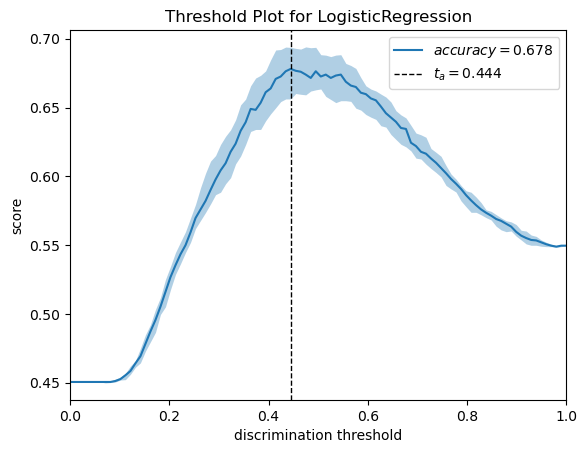

Discrimination Threshold = 0.444


In [10]:
decision_maker = ['accuracy', 'max']
scoring = "accuracy"
# Discrimination Threshold
orig_threshold = discrimination_threshold(orig_ml_model, 
                                         processed_X,
                                         y,
                                         decision_maker=decision_maker,
                                         metrics=[decision_maker[0]], 
                                         show=True,
                                         random_seed=random_seed)
print(f"Discrimination Threshold = {orig_threshold:.3f}")

In [11]:
orig_acc_score = binary_threshold_score(orig_ml_model, 
                                        X_test, 
                                        y_test,
                                        scoring=scoring,  
                                        threshold=orig_threshold)
print(f"Original accuracy score = {orig_acc_score:.3f}")

Original accuracy score = 0.689


### 3. Fairness Metric Assessment

In [12]:
testing_data = pd.concat([X_test, y_test], axis=1)
training_data = pd.concat([X_train, y_train], axis=1)

In [13]:
# Instantiate FAIR object
fair_object = FAIR(ml_model=orig_ml_model,
                   training_data=training_data,
                   testing_data=testing_data, 
                   target_variable=target_var,
                   protected_variable="sex", 
                   privileged_class=1.0,
                   threshold=orig_threshold,
                   random_seed=random_seed) 

In [14]:
metric_name='statistical_parity_ratio'
orig_fairness_metric_score = fair_object.fairness_metric(metric_name)
print(f"Original Fairness Metric = {orig_fairness_metric_score:.3f}")

Original Fairness Metric = 0.497


### 4. Compare Performance of Each Mitigation Method

In [15]:
# Print available bias mitigation methods for statistical_parity_ratio
fair_object.print_bias_mitigation_methods(metric_name)

Available bias mitigation methods for 'statistical_parity_ratio' are:
1 'disparate-impact-remover'
2 'resampling'
3 'resampling-preferential'
4 'reweighing'


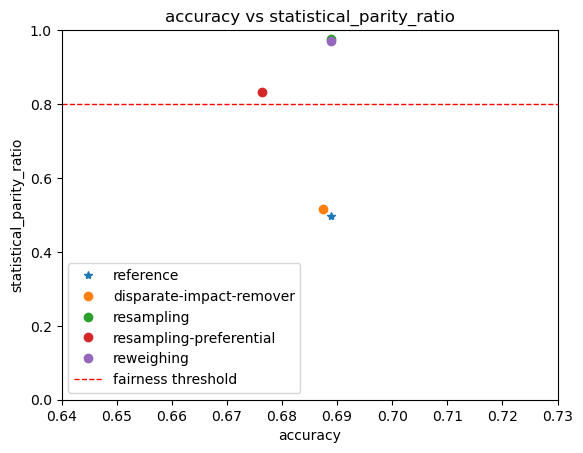

                          accuracy  statistical_parity_ratio  \
reference                 0.688843                  0.497075   
disparate-impact-remover  0.687457                  0.517105   
resampling                0.688843                  0.976657   
resampling-preferential   0.676369                  0.832151   
reweighing                0.688843                  0.970123   

                          discrimination_threshold  
reference                                 0.444444  
disparate-impact-remover                  0.454545  
resampling                                0.424242  
resampling-preferential                   0.444444  
reweighing                                0.424242  


In [16]:
df = fair_object.compare_mitigation_methods(metric_name=metric_name, 
                                            scoring=scoring, 
                                            show=True,
                                            compute_discrimination_threshold=True,
                                            decision_maker=decision_maker)
print(df)

### 5. Apply Reweighing Mitigation and Re-evaluate F1 Score and Fairness Metric

In [17]:
mitigation_method = "reweighing"
mitigation = fair_object.bias_mitigation(mitigation_method = mitigation_method)

# extract mitigated weights
mitigated_weights = mitigation['weights']

# Train the second machine learning model using the mitigated weights
ml_model = clone(orig_ml_model)
ml_model.fit(X_train, y_train, sample_weight=mitigated_weights)

LogisticRegression()

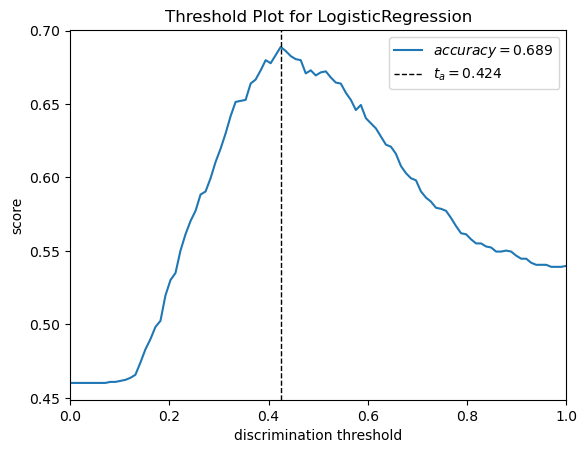

Discrimination Threshold = 0.424


In [18]:
# We can also find the optimal discrimination threshold for this new model
threshold = discrimination_threshold(ml_model, 
                                     X_test,
                                     y_test,
                                     decision_maker=decision_maker,
                                     metrics=[decision_maker[0]], 
                                     show=True,
                                     model_training=False,
                                     random_seed=random_seed)
print(f"Discrimination Threshold = {threshold:.3f}")

In [19]:
acc_score = binary_threshold_score(ml_model, 
                                   X_test, 
                                   y_test, 
                                   scoring=scoring, 
                                   threshold=threshold)
print(f"Mitigated accuracy score = {acc_score:.3f}")

Mitigated accuracy score = 0.689


In [20]:
# Instantiate FAIR object
fair_object = FAIR(ml_model=ml_model,
                   training_data=training_data,
                   testing_data=testing_data, 
                   target_variable=target_var,
                   protected_variable="sex", 
                   privileged_class=1.0,
                   threshold=threshold,
                   random_seed=random_seed) 

In [21]:
fairness_metric_score = fair_object.fairness_metric(metric_name)
print(f"Mitigated Fairness Metric = {fairness_metric_score:.3f}")

Mitigated Fairness Metric = 0.988


In [22]:
print(f"Original Accuracy score = {orig_acc_score:.3f} and Mitigated Accuracy score = {acc_score:.3f}")
print(f"Orginal Fairness Score = {orig_fairness_metric_score:.3f} and Mitigated Fairness Score = {fairness_metric_score:.3f}")

Original Accuracy score = 0.689 and Mitigated Accuracy score = 0.689
Orginal Fairness Score = 0.497 and Mitigated Fairness Score = 0.988


### 6. Paired t Test

In [23]:
# Paired t test between original Machine Learning model and "applying the mitigation method".
# Fairness metric comparison
results = paired_ttest(orig_ml_model,
                        processed_X,
                        y,
                        method="5x2cv",
                        threshold=orig_threshold,
                        fair_object=fair_object,
                        mitigation_method=mitigation_method,
                        scoring=metric_name,
                        random_seed=random_seed)
print("5x2cv paired t-test using fairness metric. (chi2, p) =", results)

100%|██████████| 5/5 [00:01<00:00,  3.70it/s]

5x2cv paired t-test using fairness metric. (chi2, p) = (-7.779354900427001, 0.0005618437068552218)


In [24]:
# Paired t test between original Machine Learning model and "applying the mitigation method".
# Fairness metric comparison computing the discrimination threshold
results = paired_ttest(orig_ml_model,
                        processed_X,
                        y,
                        method="5x2cv",
                        fair_object=fair_object,
                        mitigation_method=mitigation_method,
                        scoring=metric_name,
                        compute_discrimination_threshold=True,
                        decision_maker=decision_maker,
                        random_seed=random_seed)
print("5x2cv paired t-test using fairness metric. (chi2, p) =", results)

100%|██████████| 5/5 [00:06<00:00,  1.24s/it]

5x2cv paired t-test using fairness metric. (chi2, p) = (-4.543609658793597, 0.006148344682532446)


In [25]:
# Paired t test between original Machine Learning model and "applying the mitigation method".
# Accuracy comparison
results = paired_ttest(orig_ml_model,
                        processed_X,
                        y,
                        method="5x2cv",
                        threshold=orig_threshold,
                        fair_object=fair_object,
                        mitigation_method=mitigation_method,
                        scoring=scoring,
                        random_seed=random_seed)
print("5x2cv paired t-test using accuracy metric. (chi2, p) =", results)

100%|██████████| 5/5 [00:01<00:00,  3.75it/s]

5x2cv paired t-test using accuracy metric. (chi2, p) = (3.0512573143523185, 0.028383565921270993)


In [26]:
# Paired t test between original Machine Learning model and "applying the mitigation method".
# Accuracy comparison computing the discrimination threshold
results = paired_ttest(orig_ml_model,
                        processed_X,
                        y,
                        method="5x2cv",
                        fair_object=fair_object,
                        mitigation_method=mitigation_method,
                        scoring=scoring,
                        compute_discrimination_threshold=True,
                        decision_maker=decision_maker,
                        random_seed=random_seed)
print("5x2cv paired t-test using accuracy metric. (chi2, p) =", results)

100%|██████████| 5/5 [00:04<00:00,  1.05it/s]

5x2cv paired t-test using accuracy metric. (chi2, p) = (2.323790007724456, 0.06773301776557134)
